# Experimenting with Residual Networks

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm

from models import LeNet5, ResNet, xavier_weights, kaiming_weights
from residuals import ConvResBlock, ConvPlainBlock
from data import _load_torch_data
from training import CallBacks, Trainer, Stream
from viz import plot_training_results

The following parameters are also used as default in the Streamlit app:

In [ ]:
batch_size = 128
val_size = 0.10
n_epochs = 65
initialization = "xavier"  # or "kaiming"
path = "./derivatives"

# multi-labels (K = 10) classification task
criterion = nn.CrossEntropyLoss()

if not os.path.exists(path):
    os.mkdir(path)
    os.mkdir(path + "/models")
    os.mkdir(path + "/figures")

## Loading the CIFAR-10 dataset from torchvision

In [ ]:
train_loader, validation_loader, test_loader, classes = _load_torch_data(
    data_path="sample_data",
    dataset_name="CIFAR10",
    batch_size=batch_size,
    val_size=val_size
)
input_size = next(iter(train_loader))[0].shape

def run_model(model_):
    """ helper function to train a model based on the globals variables of the environment """
    if initialization == "xavier":
        xavier_weights(lenet)
    elif initialization == "kaiming":
        kaiming_weights(lenet)

    optimizer = optim.SGD(lenet.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=40, gamma=0.1, verbose=True)

    trainer = Trainer(lenet, optimizer, scheduler, criterion, callbacks=CallBacks(Stream(print, tqdm)),
                    device=torch.device("cuda"), save_path=path + "/models")
    training_out = trainer.fit(train_loader, validation_loader, n_epochs=n_epochs, save_epo_state=False)

    return training_out, trainer

Files already downloaded and verified
Files already downloaded and verified


## Running the networks

### LeNet-5 as a performance baseline

In [ ]:
lenet = LeNet5(input_size[1], len(classes), input_size[-1])
lenet_out, trainer = run_model(lenet)
lenet_out.to_csv(path + "/resnet20_training_out.csv")

test_loss, accuracy = trainer.run_test(test_loader)
lenet_out_per_class = trainer.run_test_per_class(test_loader)
last_row = pd.DataFrame({
    "classes": "all",
    "accuracy": accuracy,
    "loss": test_loss,
    "n_instances": len(test_loader.dataset)
    }, index=[0])
lenet_out_per_class = pd.concat([lenet_out_per_class, last_row], ignore_index=True)
lenet_out_per_class.to_csv(path + "/lenet_results_test_per_class.csv")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### ResNet-20 vs Plain-20 : do residual blocks stabilize the learning ?

In [ ]:
resnet20 = ResNet(input_size[1], len(classes), module_list=[6, 6, 6], features_shapes=[16, 32, 64], block_type=ConvResBlock)
resnet20_out, trainer = run_model(resnet20)
resnet20_out.to_csv(path + "/resnet20_training_out.csv")

test_loss, accuracy = trainer.run_test(test_loader)
resnet20_out_per_class = trainer.run_test_per_class(test_loader)
last_row = pd.DataFrame({
    "classes": "all",
    "accuracy": accuracy,
    "loss": test_loss,
    "n_instances": len(test_loader.dataset)
    }, index=[0])
resnet20_out_per_class = pd.concat([resnet20_out_per_class, last_row], ignore_index=True)
resnet20_out_per_class.to_csv(path + "/resnet20_results_test_per_class.csv")

In [ ]:
plain20 = ResNet(input_size[1], len(classes), module_list=[6, 6, 6], features_shapes=[16, 32, 64], block_type=ConvPlainBlock)
plain20_out, trainer = run_model(plain20)
plain20_out.to_csv(path + "/plain20_training_out.csv")

test_loss, accuracy = trainer.run_test(test_loader)
plain20_out_per_class = trainer.run_test_per_class(test_loader)
last_row = pd.DataFrame({
    "classes": "all",
    "accuracy": accuracy,
    "loss": test_loss,
    "n_instances": len(test_loader.dataset)
    }, index=[0])
plain20_out_per_class = pd.concat([plain20_out_per_class, last_row], ignore_index=True)
plain20_out_per_class.to_csv(path + "/plain20_results_test_per_class.csv")

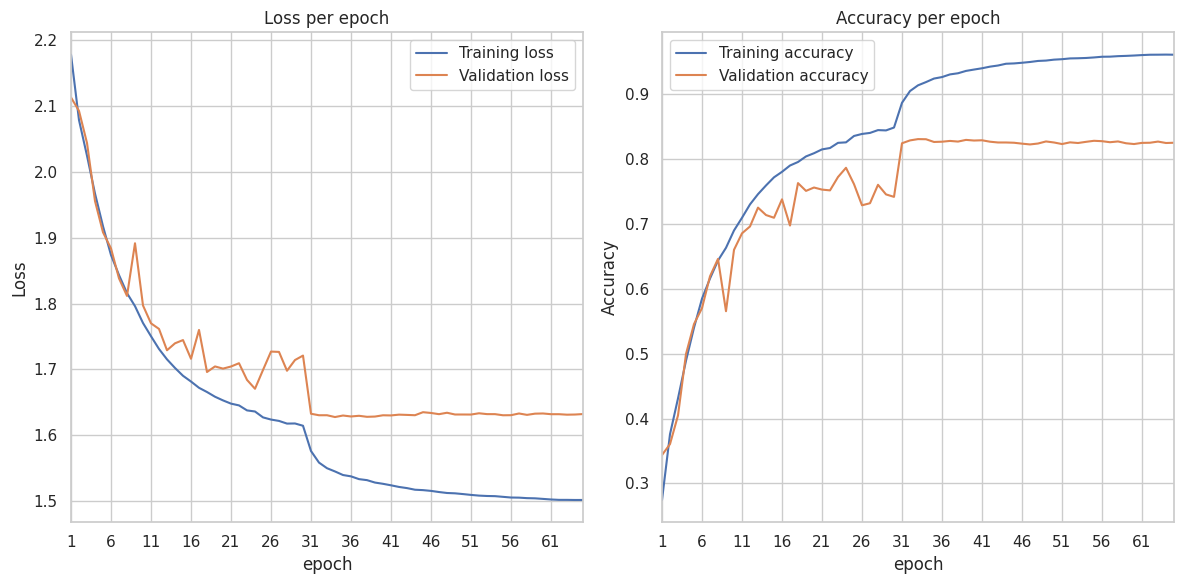

1.6316941810559622 0.8295
      classes  accuracy      loss  n_instances
0    airplane      87.5  1.631235       1000.0
1  automobile      91.0  1.632290       1000.0
2        bird      74.9  1.632624       1000.0
3         cat      66.6  1.632093       1000.0
4        deer      81.5  1.631446       1000.0
5         dog      74.5  1.631419       1000.0
6        frog      85.0  1.631329       1000.0
7       horse      85.9  1.630695       1000.0
8        ship      92.1  1.630036       1000.0
9       truck      90.5  1.630200       1000.0


In [ ]:
fig = plot_training_results(training_out)
fig.savefig(path + "/figures/training_results_2.png")
plt.show()

test_loss, accuracy = trainer.run_test(test_loader)
print(test_loss, accuracy)
out = trainer.run_test_per_class(test_loader)
out.to_csv(path + "/restuls_test_per_class_2.csv")
print(out)